# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
!pip install pandas numpy scikit-learn nltk tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Download the Dataset

In [3]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 32.4MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [4]:
df = pd.read_csv('/content/spam.csv',encoding='latin-1')

df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [5]:
df.sample(3)

,text,label
4857,Ok... https://link1.com,ham
4161,How's it going? Got any exciting karaoke type ...,ham
1896,I tot u outside cos darren say u come shopping...,ham


In [6]:
df.shape

(5572, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.isnull().sum()

,0
text,0
label,0


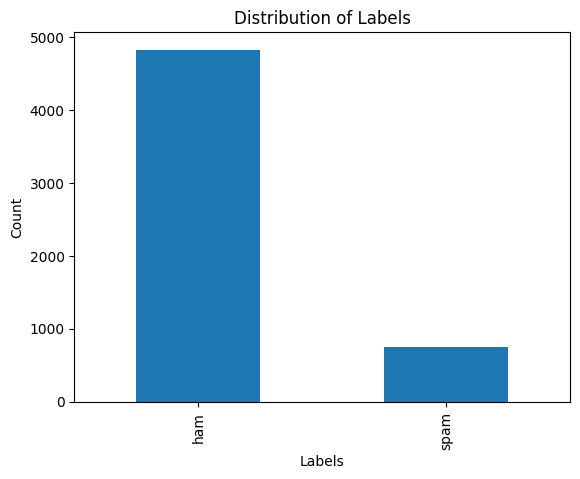

In [9]:
# we have unbalance data shoud be fix it

label_counts = df['label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

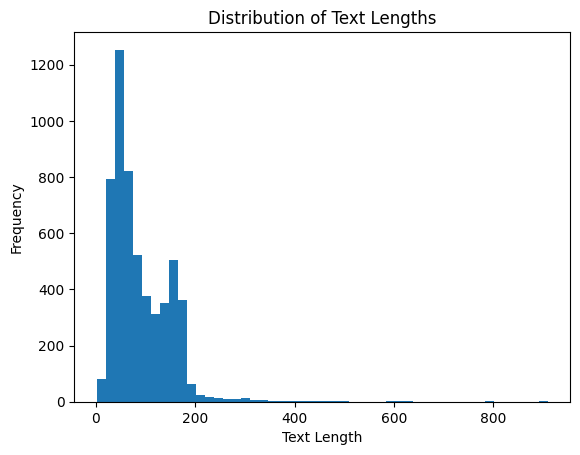

In [10]:
df['text_length'] = df['text'].apply(len)
df['text_length'].plot(kind='hist', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

nlpaug __ it is used for data augumantation

In [11]:
df.dropna(axis=0)

,text,label,text_length
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,173
3,U dun say so early hor... U c already then say...,ham,67
4,"Nah I don't think he goes to usf, he lives aro...",ham,79
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,181
5568,Will Ã_ b going to esplanade fr home?,ham,38
5569,"Pity, * was in mood for that. So...any other s...",ham,75
5570,The guy did some bitching but I acted like i'd...,ham,125


In [12]:
df.sample(60)

,text,label,text_length
1447,DonÂÃÃ·t give a flying monkeys wot they thin...,ham,113
3630,Thank you princess! You are so sexy...,ham,38
4724,There'll be a minor shindig at my place later ...,ham,70
2567,I dont want to hear anything https://link1.com,ham,46
3943,"Until 545 lor... Ya, can go 4 dinner together...",ham,48
3468,All day working day:)except saturday and sunda...,ham,67
688,Thanks love. But am i doing torch or bold.,ham,42
3744,"Aight, let me know when you're gonna be around...",ham,68
5326,What makes you most happy?,ham,26
3163,TODAY is Sorry day.! If ever i was angry with ...,ham,148


In [13]:
min_word_count = 10
max_word_count = 200

df = df[df['text'].apply(lambda x: min_word_count <= len(x.split()) <= max_word_count)]

In [14]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# remove url
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

df['text'] = df['text'].apply(remove_urls)

In [16]:
# this for removes any non-alphabetical

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

df['text'] = df['text'].apply(remove_special_characters)


In [17]:
# for lowercasing
df['text'] = df['text'].str.lower()

In [18]:
# Removing English stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['text'] = df['text'].apply(remove_stopwords)

In [19]:
# Stemming

def stemming(text):
  return ' '.join([word for word in text.split() if word not in stemming])

  df['text'] = df['text'].apply(stemming)

In [20]:
# cheek for any change in text

df['text'].iloc[10]

'six chances win cash pounds txt csh send cost pday days tsandcs apply reply hl info'

In [21]:
# clean text
def clean_text(text):
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_stopwords(text)
    return text


df['clean_text'] = df['text'].apply(clean_text)

In [22]:
df['clean_text'].head()

,clean_text
0,go jurong point crazy available bugis n great ...
2,free entry wkly comp win fa cup final tkts st ...
3,u dun say early hor u c already say
4,nah dont think goes usf lives around though
5,freemsg hey darling weeks word back id like fu...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training data shape: (2844, 80)
Testing data shape: (711, 80)
Training labels shape: (2844,)
Testing labels shape: (711,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [37]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length))
model.add(Bidirectional(SimpleRNN(units=64, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=64)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [38]:
print(X_train.shape)
print(X_test.shape)

(2844, 80)
(711, 80)


In [39]:
history = model.fit(X_train, y_train, epochs=6, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8041 - loss: 0.4620 - val_accuracy: 0.9212 - val_loss: 0.2458
Epoch 2/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9742 - loss: 0.0767 - val_accuracy: 0.9705 - val_loss: 0.1000
Epoch 3/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9973 - loss: 0.0100 - val_accuracy: 0.9677 - val_loss: 0.1434
Epoch 4/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9705 - val_loss: 0.1234
Epoch 5/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 7.6300e-04 - val_accuracy: 0.9677 - val_loss: 0.1493
Epoch 6/6
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.5531e-04 - val_accuracy: 0.9691 - val_loss: 0.1597


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9717 - loss: 0.1802
Test Loss: 0.15974842011928558
Test Accuracy: 0.9690576791763306


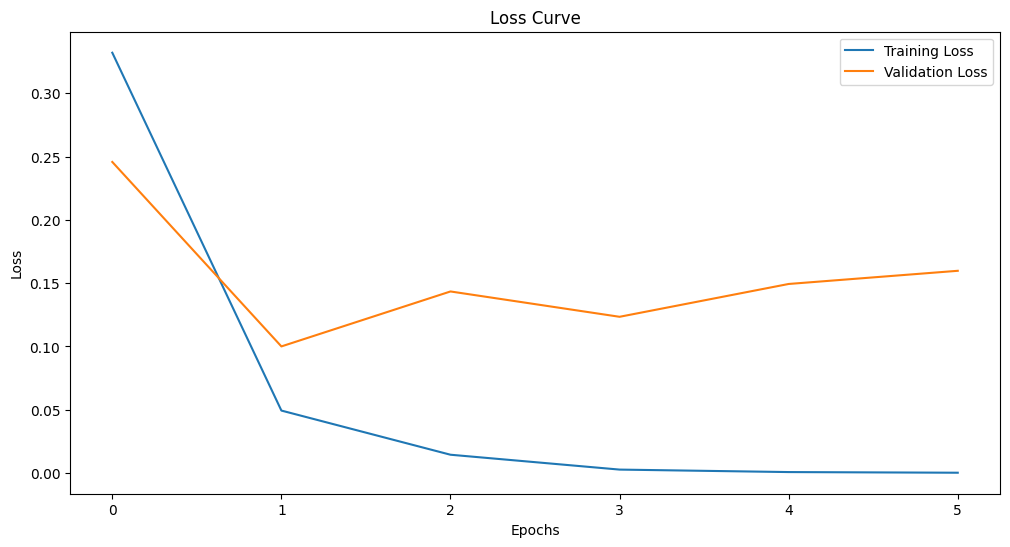

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [42]:
new_texts = ['Compliments of the day to you, I have decided to reach out to you after going through your profile. I got your email contact through a Business Trade Manual in my search for a foreign business partner and I have an interesting proposal which will interest you, it is of mutual benefit. Please, let me know if I can share details about myself and the proposal to this particular email. Thank you, Mr. Alexander Liu']
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')
predictions = model.predict(new_padded_sequences)

for i, prediction in enumerate(predictions):
    print(f"Review: {new_texts[i]}")
    print(f"Prediction (probability): {prediction[0]}")
    if prediction[0] > 0.5:
        print("Predicted class: ham")
    else:
        print("Predicted class: spam")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
Review: Compliments of the day to you, I have decided to reach out to you after going through your profile. I got your email contact through a Business Trade Manual in my search for a foreign business partner and I have an interesting proposal which will interest you, it is of mutual benefit. Please, let me know if I can share details about myself and the proposal to this particular email. Thank you, Mr. Alexander Liu
Prediction (probability): 8.542694558855146e-05
Predicted class: spam


In [43]:
new_texts = ["The sender's intention behind ham emails is to communicate a legitimate message. Individuals, organizations, or services typically send these emails with the genuine purpose of providing information, conducting business, or engaging in personal or professional communication. Ham emails are usually helpful, informative, or meaningful to the recipient."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')
predictions = model.predict(new_padded_sequences)

for i, prediction in enumerate(predictions):
    print(f"Review: {new_texts[i]}")
    print(f"Prediction (probability): {prediction[0]}")
    if prediction[0] > 0.5:
        print("Predicted class: ham")
    else:
        print("Predicted class: spam")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Review: The sender's intention behind ham emails is to communicate a legitimate message. Individuals, organizations, or services typically send these emails with the genuine purpose of providing information, conducting business, or engaging in personal or professional communication. Ham emails are usually helpful, informative, or meaningful to the recipient.
Prediction (probability): 0.9995775818824768
Predicted class: ham


# Here website find example of ham email example
https://guardiandigital.com/resources/faq/ham-vs-spam#:~:text=Examples%20of%20ham%20emails%20include,from%20reputable%20social%20media%20platforms.

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach? becuse to clean the data .

- Why did you choose this model design? I think it is good in this task SimpleRNN.

- Why did you pick this number of layers or units for the model? i try different number but i think still have overfitting.

- Why did you select these evaluation methods? to assess the model performance on the test dataset, and see gab it seem somthing wrong or not learning correctly but it woorks.

- Does your model show signs of overfitting or underfitting? How do you know? yes overfitting becuse in training i see start with 100 acc.

- What changes could you make to improve the model and fix overfitting or underfitting? handel layers of model.

Answer Here: